<a href="https://colab.research.google.com/github/rohith033/oelp/blob/master/book_det_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import cv2 
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


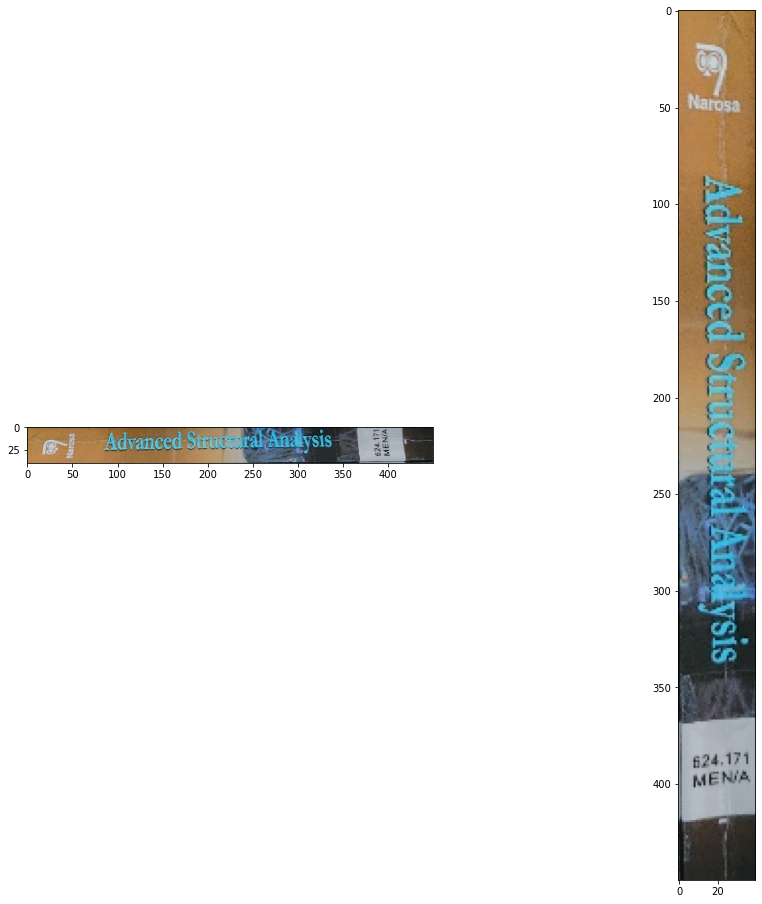

In [28]:
img = cv2.imread('./book3.jpeg')
tmp=[]
tmp.append(img)
rot = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
tmp.append(rot)
fig,axies = plt.subplots(1,2,figsize=(16,16))
for i,ax in enumerate(axies.flat):
  ax.imshow(tmp[i])

In [35]:
rot = cv2.cvtColor(rot,cv2.COLOR_BGR2GRAY)


error: ignored

In [36]:
print(rot)

[[122 121 120 ... 115 110  92]
 [124 124 123 ... 107  97  90]
 [124 124 124 ... 101 110  81]
 ...
 [ 68  22  14 ...  32  30  30]
 [ 75  20  14 ...  32  33  32]
 [ 74  19  15 ...  33  32  31]]


In [47]:
print(rot[0])
print(len(rot))
print(rot[375])
max_sum=0
min_sum=1e6
min_idx=0
idx=0
for i in range(0,450):
  if(np.sum(rot[i])<min_sum):
    min_sum = min(min_sum,np.sum(rot[i]))
    min_idx=i
  if(np.sum(rot[i])>max_sum):
    max_sum = np.sum(rot[i])
    idx = i

print(max_sum)
print(idx)
print(min_idx)
print(min_sum)
# this test concludes going with max would give more accurate results as 
# there is chance of presence of complet black outside of code box
# as there is chance of presence of complete white outside of the code box 
# but this has a higher cance of giving correct result

[122 121 120 122 124 124 122 123 121 123 119 119 119 122 125 116 111 116
 115 117 116 122 117 117 120 108 115 130 114 111 118 114 113 117 110 108
 110 115 110  92]
450
[150 116 180 178 182 185 187 189 189 191 191 186 182 182 182 180 179 180
 180 178 177 178 177 173 171 175 173 179 180 181 179 180 181 179 179 178
 178 177 176 174]
7155
378
444
1463


In [ ]:
# sticker is standard so the size is in the range of 50's
